# Full Localisation Of Talkers

In [1]:
## Simulation
def normalise(X):
    X = X/np.max(np.abs(X))
    return X

def make_mono(data):
    try:
        if len(data[0]) == 2:
            data = np.matrix.transpose(data)
            data = normalise(data[0] + data[1])
    except:
        data = data
    return data

def downsample(fs, data, target_samplerate):
    if target_samplerate == fs/2:
        output = []
        for i in range(len(data)):
            if i%2 == 0:
                output.append(data[i])
        output_samplerate = target_samplerate
    elif target_samplerate == fs:
        output = data
        output_samplerate = fs
    else: 
        output_samplerate = fs
    return output_samplerate, output

def process_path(path):
    import wave, os, glob
    list_ = []
    if os.path.exists(path):
        for filename in glob.glob(os.path.join(path, '*.wav')):
            list_.append(filename)
    else:
         print(path + ' does not exist')   

    # ----------- process each file in the list --------- 
    from scipy.io import wavfile
    import numpy as np

    # 1. check for useful data 
    list2_ = []
    exceptions = 0
    for file in list_:
        try:
            fs, data = wavfile.read(file) # read 
            data = np.array(data, dtype=np.float32)
            list2_.append(file)
        except: 
            exceptions += 1
    print('no of exceptions: ' + str(exceptions))
    return list2_

def an(w, n, MIC_ARRAY, theta, c):
    X = np.exp((-1j) * w * (MIC_ARRAY[1][n]*np.sin(theta)/c))
    return X

def sn(A, phi, k, x):
    S = A*np.exp(1j*phi)*np.exp(-1j*k*x)
    return S

def generate_linear_array(N, L):
    N = N - 1
    X_POS = [(L * n/N) - L/2 for n in range(N + 1)]
    Y_POS = np.zeros(len(X_POS))
    MIC_ARRAY = [Y_POS, X_POS]
    Mic = [[MIC_ARRAY[j][i] for j in range(len(MIC_ARRAY))] for i in range(len(MIC_ARRAY[0]))]
    return MIC_ARRAY, Mic

def line_array(f, MIC_ARRAY, Mic, N, res, Sx, Sy):
    theta = np.linspace(-np.pi/2, np.pi/2, res)
    A = 1;
    phi = 0;
    w = 2*np.pi*f;
    c = 343;
    lamb = c/f;
    k = w/c;
    d_max = lamb/2;
        
    P=np.zeros((len(theta),1), dtype=complex)
    for th in range(0, len(theta)):
        p=np.zeros((N,1), dtype=complex)
        for n in range(0, N):
            Mic_x = Mic[n][0]
            Mic_y = Mic[n][1]
    
            x = np.sqrt((Sx-Mic_x)**2+(Sy-Mic_y)**2)
            s = sn(A, phi, k, x)
            a = an(w, n, MIC_ARRAY, theta[th], c)
            p[n] = s * a
            
        P[th] = np.sum(p)
        
    return [P, theta]

def minus3db(P):
    maxP = max(abs(P))
    maxP_sqrt2 = maxP/np.sqrt(2)
    return maxP_sqrt2

def find_width(theta, P): 
    maxP_sqrt2 = minus3db(abs(P))
    
    i = 0
    # Here is the bit that finds the index of the array
    index = []
    new_peak = []
    index_flag = 0
    for p in abs(P):
        if p > maxP_sqrt2:
            index.append(i)
            new_peak.append(p)

        i += 1
    beam_th = theta[index]

    BEAM_WIDTH = np.max(beam_th) - np.min(beam_th)
    return BEAM_WIDTH

def equalise_length(Signal_1, Signal_2):
    if len(Signal_1) > len(Signal_2):
        Buff = np.zeros(len(Signal_1) - len(Signal_2))
        Signal_2 = np.append(Signal_2, Buff)
    elif len(Signal_2) > len(Signal_1):
        Buff = np.zeros(len(Signal_2) - len(Signal_1))
        Signal_1 = np.append(Signal_1, Buff)
    return Signal_1, Signal_2

# Function that returns the longest array in a list of arrays 
def find_max(Output):
    max_length = 0
    for i in Output:
        if len(i) >= max_length:
            max_length = len(i)
                
    for i in Output:
        if len(i) == max_length:
            Max_Out = i
    return Max_Out

def dist_atten(fs, signal, source_loc, mic_loc, phase_delay):
    # ----------------------------------------------
    # signal is the input signal as an array
    # source_loc = [x, y]
    # mic_loc = [x, y]
    # ----------------------------------------------
    data = signal
    T = 1/fs
    c = 343
    Dist = np.sqrt((source_loc[0] - mic_loc[0])**2 + (source_loc[1] - mic_loc[1])**2)
    # assuming 1/r relationship, Attenuation:
    A = 1/Dist
    Time = Dist/c
    Delay = (Time + phase_delay) * fs
    F_Delay = np.floor(Delay)
    Max_Samples = int(np.ceil(Delay))

    Max_Time_Delay = Max_Samples*T # check that the actual delay is between this and 
    Min_Time_Delay = (Max_Samples-1)*T # this

    m = Delay - F_Delay

    # 1. initial delay
    zeros = np.zeros(Max_Samples + 1)
    pre_al = np.zeros(Max_Samples + len(data))
    # Preprocess for spline interpolaton
    data_spline = np.concatenate((data,[0]))
    data_spline = A * data_spline
    data_spline = np.concatenate((zeros, data_spline))

    n=0
    for i in range(0, int(len(data)) + int(F_Delay) - 1):
        p = data_spline[n:n+4]
        pre_al[i] = cube_spline(p, m) 
        n += 1
      
    return pre_al

def cube_spline(p, m): 
    # -------------------------------------------------------
    # from fraction m (where m < 1) and samples -1 to 2 (p) 
    # the cubic spline can be used to approximate the gradient between two samples  
    # http://www.paulinternet.nl/?page=bicubic
    # --------------------------------------------
    a = -(1/2)*p[0]+(3/2)*p[1]-(3/2)*p[2]+(1/2)*p[3]
    b = p[0] - (5/2)*p[1] + 2*p[2] - (1/2)*p[3]
    c = -(1/2)*p[0] + (1/2)*p[2]
    d = p[1]
    x = m
    y = a*x**3 + b*x**2 + c*x + d
    return y

def line_array_time(Mics, Source, fs, Signal, Steer_Angle):
    # work out time delays for each mic 
    Phase = []
    if Steer_Angle > 0:
        for Mic in Mics:
            L = Mics[0][1] - Mic[1]
            T = abs(L * np.sin(Steer_Angle))/343
            Phase.append(T)
            
    if Steer_Angle == 0:
        for Mic in Mics:
            Phase.append(0)
            
    if Steer_Angle < 0:
        m = len(Mics)
        for Mic in Mics:
            L = Mics[m-1][1] - Mic[1]
            T = abs(L * np.sin(Steer_Angle))/343
            Phase.append(T)
    
    n = 0
    Output = []
    for Mic in Mics:
        Output.append(dist_atten(fs, Signal, Source, Mic, Phase[n]))
        n += 1
    
    Max_Out = find_max(Output)

    OUTPUT_FINAL = []
    for i in range(0, len(Output)):
        OUT_DISGUARD, OUT = equalise_length(Max_Out, Output[i])
        OUTPUT_FINAL.append(OUT)
    
    Out = sum(OUTPUT_FINAL)/len(OUTPUT_FINAL)
    Out = normalise(Out.astype(float))
    return Out  

def line_array_time_multi_sources(Mics, fs, Source, Signal, Steer_Angle=0):
    # work out time delays for each mic 
    Phase = []
    if Steer_Angle > 0:
        for Mic in Mics:
            L = Mics[0][1] - Mic[1]
            T = abs(L * np.sin(Steer_Angle))/343
            Phase.append(T)
            
    if Steer_Angle == 0:
        for Mic in Mics:
            Phase.append(0)
            
    if Steer_Angle < 0:
        m = len(Mics)
        for Mic in Mics:
            L = Mics[m-1][1] - Mic[1]
            T = abs(L * np.sin(Steer_Angle))/343
            Phase.append(T)
    
    n = 0
    Output = []
    for Mic in Mics:
        Y = []
        for i in range(len(Signal)):
            Y.append(dist_atten(fs, Signal[i], Source[i], Mic, Phase[n]))
        Max = find_max(Y)
        
        Equalised_output = []
        for i in range(0, len(Y)):
            OUT_DISGUARD, OUT = equalise_length(Max, Y[i])
            Equalised_output.append(OUT)
        Y_out = sum(Equalised_output)
            
        Output.append(Y_out)
        n += 1
    
    Max_Out = find_max(Output)

    OUTPUT_FINAL = []
    for i in range(0, len(Output)):
        OUT_DISGUARD, OUT = equalise_length(Max_Out, Output[i])
        OUTPUT_FINAL.append(OUT)
    
    return OUTPUT_FINAL

## Voice Activity Detection
def process_path_to_list(path):
    import wave, os, glob
    list_ = []
    if os.path.exists(path):
        for filename in glob.glob(os.path.join(path, '*.pkl')):
            list_.append(filename)
    else:
        print('Does Not Exist')

    return list_

def normalise(x):
    x = x/max(x)
    return(x)

class TimeFrameFeatures:
    
    def __init__(self, windowLength, windowOverlap, timeFrameLength, timeFrameOverlap):
        
        self.windowLength = windowLength
        self.windowOverlap = windowOverlap
        self.timeFrameLength = timeFrameLength
        self.timeFrameOverlap = timeFrameOverlap
        
        self.threshold = 0
        self.timeFrames = []
        self.MFCCFrames = []
        self.ZCRFrames = []
        self.CENTFrames = []
        self.RMSFrames = []
        self.SPEC_ENTFrames = []
        self.waveformFrames = []
        self.MFCCList = []
    
    def process_data(self, fs, data, label_array):
        from python_speech_features import mfcc

        windowsPerFrame = int(round(self.timeFrameLength/self.windowLength))
        framesPerSecond = int(round(fs * self.timeFrameLength))
        NframesPerFile = int(len(data)/(framesPerSecond*self.timeFrameOverlap))

        self.threshold = 0
        self.timeFrames = []
        self.labelFrames = []
        self.MFCCFrames = []
        self.ZCRFrames = []
        self.CENTFrames = []
        self.RMSFrames = []
        self.SPEC_ENTFrames = []
        self.waveformFrames = []
        self.MFCCList = []
        self.absTimeList = []
        for frameNum in range(NframesPerFile):
            absTime = (frameNum*self.timeFrameOverlap*self.timeFrameLength)
            C = int(round((frameNum*self.timeFrameOverlap)*framesPerSecond))
            D = int(round((frameNum*self.timeFrameOverlap+1)*framesPerSecond))
            dataFrame = data[C:D]
            labels = label_array[C:D]
            label = max(labels)

            N = int(round(fs * self.windowLength))
            c = 1
            n = 1
            o = self.windowOverlap
            No_N = len(dataFrame)/(N*o)

            ZCR = []
            CENT = []
            RMS = []
            SPEC_ENT = []
            MFCC = []
            Time_Index = []
            Waveform = []

            NFFT = 0
            Size = True
            x = 0
            for n in range(0, int(No_N)):
                A = int(round((n*o)*N))
                B = int(round((n*o+c)*N))
                block = dataFrame[A:B]
                window = np.hanning(len(block))
                block = block * window

                cross_rate = zero_cross_rate(fs, N, block)
                spec_cent = spectral_centroid(block, fs)
                rms = rms_value(block)
                spec_entropy = spectral_entropy(block)

                while Size == True:
                    if len(block) > NFFT:
                        NFFT = 2**x
                    x += 1
                    if x == 13 or NFFT > len(block):
                        break
                mfcc_values = mfcc(block, fs, winlen=self.windowLength, nfft=NFFT, winstep=(self.windowLength)*self.windowOverlap)
                MFCC.append(mfcc_values)
                ZCR.append(cross_rate)
                CENT.append(spec_cent)
                RMS.append(rms)
                SPEC_ENT.append(spec_entropy)
                time = (n*o + c/2)*N*(1/fs)
                Time_Index.append(time)

            self.absTimeList.append(absTime)
            self.timeFrames.append(Time_Index)
            self.MFCCFrames.append(MFCC)
            Out = []
            for frame in MFCC:
                frame = frame[0]
                for f in frame:
                    Out.append(f)
            self.MFCCList.append([Out])
            self.ZCRFrames.append(ZCR)
            self.CENTFrames.append(CENT)
            self.RMSFrames.append(RMS)
            self.SPEC_ENTFrames.append(SPEC_ENT)
            self.waveformFrames.append(dataFrame) 
            self.labelFrames.append(label)
            
def zero_cross_rate(fs, N, block):
    zero_crosses = np.nonzero(np.diff(block > 0))
    no_crosses = np.size(zero_crosses) * 0.5
    cross_rate = no_crosses * fs/N
    return cross_rate

def rms_value(block):
    rms = np.sqrt(np.mean(block**2))
    return rms

def spectral_centroid(block, samplerate):
    magnitudes = np.abs(np.fft.rfft(block)) # magnitudes of positive frequencies
    length = len(block)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

def spectral_entropy(block):
    BLOCK = np.fft.fft(block)
    P_w = (1/len(BLOCK))*abs(BLOCK)**2
    P_i = P_w/sum(P_w)
    
    PSE = 0
    for p in P_i:
        PSE += p * np.log(p)
    spec_entropy = -PSE
    return spec_entropy


## Angle of Incidence Detection 

class TDOA:
    def xcor(self, Sig1, Sig2):
        Sig1 = Sig1 #*np.hanning(len(Sig1))
        Sig2 = Sig2 #*np.hanning(len(Sig2))
        
        Xi = np.fft.fft(Sig1) #[0:int(round(len(Sig1)/2))]
        Xj = np.fft.fft(Sig2) #[0:int(round(len(Sig2)/2))]

        Rij = abs(np.fft.ifft((Xi * np.conj(Xj))/(abs(Xi)*abs(Xj))))
        return Rij
    
    def xcor2(self, Sig1, Sig2):
        Sig1 = Sig1 #*np.hanning(len(Sig1))
        Sig2 = Sig2 #*np.hanning(len(Sig2))
        
        Xi = np.fft.fft(Sig1) #[0:int(round(len(Sig1)/2))]
        Xj = np.fft.fft(Sig2) #[0:int(round(len(Sig2)/2))]

        Rij = abs(np.fft.ifft((Xi * np.conj(Xj))))
        return Rij
    
    def get_dT(self, matrix, fs):
        dT = (1/fs) * np.argmax(matrix)
        return dT

    def get_angle(self, tdoa, Mics, OUTPUT, fs):
        self.all_corr = []
        SpeedOfSound = 343
        Incident = {'Left':None, 'Right':None}
        N = len(Mics[1])
        ref = N - 1
        Angles = []
        for n in range(0, len(Mics[1])-1):
            d = Mics[1][ref] - Mics[1][n]
            R = tdoa.xcor(OUTPUT[n], OUTPUT[ref])
            dT = tdoa.get_dT(R, fs)
            Phi = np.arcsin(SpeedOfSound*dT/d)
            Angles.append(Phi) 
        L_Angle = sum(Angles)/len(Angles)
        Incident['Left'] = L_Angle
        #print('Left', str(L_Angle))
        

        
        N = len(Mics[1])
        ref = 0
        Angles = []
        for n in range(1, len(Mics[1])):
            d = Mics[1][ref] - Mics[1][n]
            R = tdoa.xcor(OUTPUT[n], OUTPUT[ref])
            dT = tdoa.get_dT(R, fs)
            Phi = np.arcsin(SpeedOfSound*dT/d)
            Angles.append(Phi) 
        R_Angle = sum(Angles)/len(Angles)
        Incident['Right'] = R_Angle
        #print('Right', str(R_Angle))

        return Incident
    
    def get_angle2(self, tdoa, Mics, OUTPUT, fs):
        self.all_corr = []
        SpeedOfSound = 343
        Incident = {'Left':None, 'Right':None}
        N = len(Mics[1])
        ref = N - 1
        Angles = []
        for n in range(0, len(Mics[1])-1):
            d = Mics[1][ref] - Mics[1][n]
            R = tdoa.xcor2(OUTPUT[n], OUTPUT[ref])
            self.all_corr.append(R)
            dT = tdoa.get_dT(R, fs)
            Phi = np.arcsin(SpeedOfSound*dT/d)
            Angles.append(Phi) 
        L_Angle = sum(Angles)/len(Angles)
        Incident['Left'] = L_Angle
        #print('Left', str(L_Angle))

        
        N = len(Mics[1])
        ref = 0
        Angles = []
        for n in range(1, len(Mics[1])):
            d = Mics[1][ref] - Mics[1][n]
            R = tdoa.xcor2(OUTPUT[n], OUTPUT[ref])
            self.all_corr.append(R)
            dT = tdoa.get_dT(R, fs)
            Phi = np.arccos(SpeedOfSound*dT/d)
            Angles.append(Phi) 
        R_Angle = sum(Angles)/len(Angles)
        Incident['Right'] = R_Angle
        #print('Right', str(R_Angle))

        return Incident
    
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, fs, highpass=125, lowpass=4000, order=5):
    data = butter_highpass_filter(data, highpass, fs, order=order)
    data = butter_lowpass_filter(data, lowpass, fs, order=order)
    return data

def Generate_Phase(Mics, Steer_Angle):
    Phase = []
    if Steer_Angle > 0:
        for Mic in Mics:
            L = Mics[0][1] - Mic[1]
            T = abs(L * np.sin(Steer_Angle))/343
            Phase.append(T)

    if Steer_Angle == 0:
        for Mic in Mics:
            Phase.append(0)

    if Steer_Angle < 0:
        m = len(Mics)
        for Mic in Mics:
            L = Mics[m-1][1] - Mic[1]
            T = abs(L * np.sin(Steer_Angle))/343
            Phase.append(T)
    return Phase

def Delay(data, fs, phase_delay):
    T = 1/fs
    Delay = (phase_delay) * fs
    F_Delay = np.floor(Delay)
    Max_Samples = int(np.ceil(Delay))

    Max_Time_Delay = Max_Samples*T # check that the actual delay is between this and 
    Min_Time_Delay = (Max_Samples-1)*T # this

    m = Delay - F_Delay

    # 1. initial delay
    zeros = np.zeros(Max_Samples + 1)
    pre_al = np.zeros(Max_Samples + len(data))
    # Preprocess for spline interpolaton
    data_spline = np.concatenate((data,[0]))
    data_spline = np.concatenate((zeros, data_spline))

    n=0
    for i in range(0, int(len(data)) + int(F_Delay) - 1):
        p = data_spline[n:n+4]
        pre_al[i] = cube_spline(p, m) 
        n += 1
    return pre_al

def Beam_Form(OUTPUT, fs, Phase):
    OUT = []
    for n in range(0, len(OUTPUT)):
        OUT.append(Delay(OUTPUT[n], fs, Phase[n]))

    Max_Out = find_max(OUT)
    OUT_FINAL = []
    for i in range(0, len(OUT)):
        OUT_DISGUARD, equal = equalise_length(Max_Out, OUT[i])
        OUT_FINAL.append(equal)

    FullOutput = np.zeros(len(OUT_FINAL[0]))
    for out in OUT_FINAL:
        FullOutput += butter_bandpass_filter(out, fs)

    FullOutput = normalise(FullOutput)
    return FullOutput

## Simulation 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


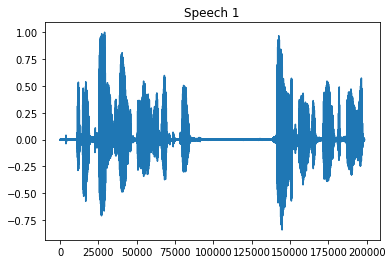

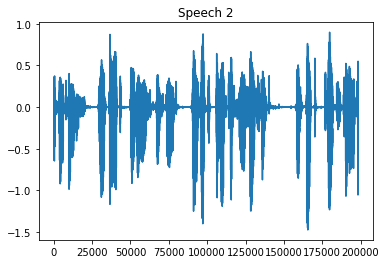

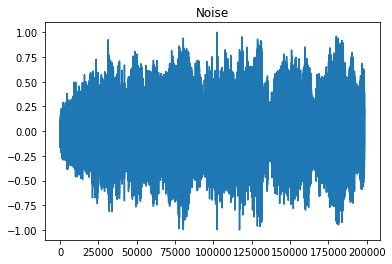

In [2]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

# input files are currently corrupted, change them to something reasonable. 
# rewrite all of this and change them to see fit. 
# this should be good!!!!
fs_s1, speech1 = wavfile.read('TestSpeech1.wav')
fs_s2, speech2 = wavfile.read('TestSpeech2.wav')
fs_n1, noise1 = wavfile.read('TestNoise1.wav')

speech1 = normalise(speech1)
speech2 = normalise(speech2)
noise1 = make_mono(noise1)
fs, noise1 = downsample(fs_n1, noise1, fs_s1)
noise1 = normalise(noise1)

# Only pick 10 seconds of audio 
A = 1
B = 10
A = int(round(fs*A))
B = int(round(fs*B))
speech1 = speech1[A:B]
speech2 = speech2[A:B]
noise1 = noise1[A:B]

plt.plot(speech1)
plt.title('Speech 1')
plt.show()
plt.plot(speech2)
plt.title('Speech 2')
plt.show()
plt.plot(noise1)
plt.title('Noise')
plt.show()

### Place in 2D Space

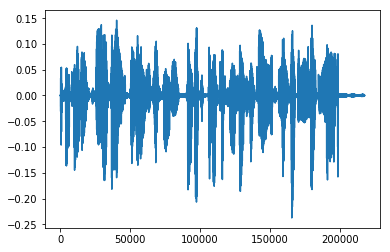

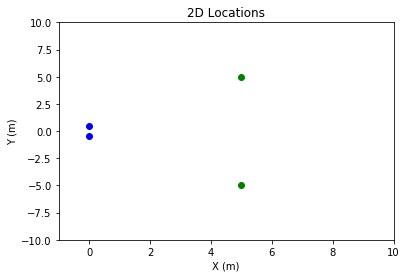

In [3]:
import numpy as np
N = 2 # number of mics 
L = 0.9 # length of mic array
Mics, mic = generate_linear_array(N, L)

speechLoc_1 = [5, 5] # [x, y] in meters
speechLoc_2 = [5, -5] # [x, y] in meters
noiseLoc_1 = [300, 1]

Source = [speechLoc_1, speechLoc_2, noiseLoc_1]
Signal = [speech1, speech2, noise1]
OUTPUT = line_array_time_multi_sources(mic, fs, Source, Signal)

timeArrayInput = np.linspace(0, (1/fs)*len(OUTPUT[0]), len(OUTPUT[0]))
plt.plot(OUTPUT[0])
plt.show()

wavfile.write('Comparison.wav', fs, normalise(OUTPUT[0]))

plt.scatter(Mics[0], Mics[1], color='b')
plt.scatter(speechLoc_1[0], speechLoc_1[1], color='g')
plt.scatter(speechLoc_2[0], speechLoc_2[1], color='g')
plt.scatter(noiseLoc_1[0], noiseLoc_1[1], color='r')
plt.xlim([-1, 10])
plt.ylim([-10, 10])
plt.title('2D Locations')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

The above simulations give the audio outputs for microphones at the desired locations with the relevand amplitude attanuations ($1/distance$) and time attenuation depending on their location in space. 

Anechoic Conditions are assumed

# Voice Activity Detection

In [4]:
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import math
from scipy import signal

RandomForest = joblib.load('RandomForest_VAD_mfcc-zcr.pkl')
INPUT_LENGTH = 336 # declare input vector length

data = OUTPUT[0] # take input from a reference microhpone
data = butter_bandpass_filter(data, fs)

data = normalise(data)
timearray = np.linspace(0, len(data)*(1/fs), len(data))

timeFrameLength = 250 / 1000 # 250ms
file_length_in_seconds = len(data) * 1/fs
frames_in_file = int(np.floor(file_length_in_seconds/timeFrameLength))
nFrameLength = timeFrameLength * fs
overlap = 0.5

windowLength = 20 / 1000

placeholder = np.zeros(len(data))
feat = TimeFrameFeatures(windowLength, overlap, timeFrameLength, overlap)
feat.process_data(fs, data, placeholder)
n = 0

# CENT > SPEC_ENT > ZCR > MFCC
predictions = []
nwrong = 0
times = []
out = []
for time in feat.absTimeList:
    X = []
    z = feat.ZCRFrames[n]
    #c = feat.CENTFrames[n]
    #s = feat.SPEC_ENTFrames[n]
    m = feat.MFCCList[n]
    m = m[0]
    n += 1
    #X.extend(c)
    #X.extend(s)
    X.extend(z)
    X.extend(m)
    X = np.array(X)
    if len(X) == INPUT_LENGTH:
        X = X.reshape(1, -1)
        times.append(time)
        out.append(X)
    else:
        nwrong += 1

predictions = []
for o in out:
    prediction = RandomForest.predict(o)
    predictions.append(prediction)
    

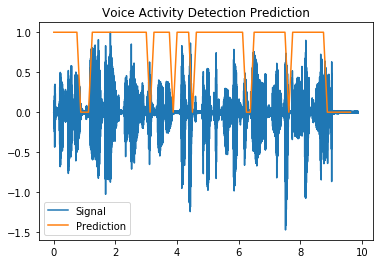

In [5]:
plt.plot(timearray, data)
plt.plot(times, predictions)
plt.legend(['Signal', 'Prediction'])
plt.title('Voice Activity Detection Prediction')
plt.show()

These predictions are then used as markers for where in the time series signal the TDOA algorithm should take frames from

## TDOA

In the time difference of arrival stage, where consecutive frames of speech are found, then the TDOA algorithm is activated

In [6]:
import math

timeFrameOverlap = overlap

windowsPerFrame = int(round(timeFrameLength/windowLength))
framesPerSecond = int(round(fs * timeFrameLength))
NframesPerFile = int(len(data)/(framesPerSecond*timeFrameOverlap))
print(NframesPerFile)
offset = 2

TimeArray = []
Output_Angles = []
for frameNum in range(len(predictions)-offset):
    absTime = (frameNum*timeFrameOverlap*timeFrameLength)
    C = int(round((frameNum*timeFrameOverlap)*framesPerSecond))
    D = int(round((frameNum*timeFrameOverlap+offset)*framesPerSecond))
    time = (1/fs)*C
    Frame = []
    one = predictions[frameNum]
    two = predictions[frameNum+1]
    #three = predictions[frameNum+2] 
    #four = predictions[frameNum+3]
    conceq = one + two #+ three + four
    if conceq == offset:
        for o in OUTPUT:
            Frame.append(o[C:D])
        tdoa = TDOA()
        Angle = tdoa.get_angle(tdoa, Mics, Frame, fs)
        for A in Angle:
            if not math.isnan(Angle[A]):
                Output_Angles.append(Angle[A])
                TimeArray.append(time)

79


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:464: RuntimeWarning: invalid value encountered in arcsin
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:479: RuntimeWarning: invalid value encountered in arcsin


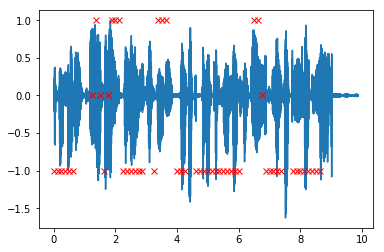

In [7]:
plt.plot(timeArrayInput, normalise(OUTPUT[0]))
plt.plot(TimeArray, normalise(Output_Angles), 'rx')
plt.show()

These angles are then fed to a Gaussian Mixture Model where a model us used to estimate talker locations from the array of TDOA locations

## Gaussian Mixture Model 

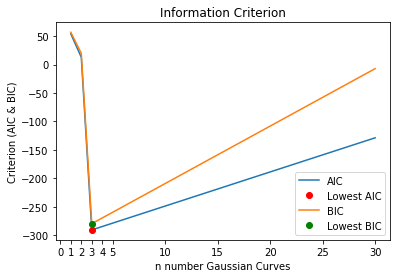

In [8]:
from sklearn.mixture import GaussianMixture
import numpy as np

R = np.array(Output_Angles).reshape(-1, 1)
AIC = []
BIC = []
N = []
num = round(len(R)/2)
lowest_aic = 1e50
lowest_bic = 1e50

test = R[num:len(R)]
train = R[0:num]

Ver = 'run'
for n in range(1, num+1):
    GM = GaussianMixture(n_components=n, covariance_type='spherical')
    GM.fit(train)
    aic = GM.aic(test)
    bic = GM.bic(test)
    AIC.append(aic)
    BIC.append(bic)
    N.append(n)
    
    if Ver == 'aic':
        if aic > lowest_aic:
            break

        if aic < lowest_aic:
            lowest_aic = aic
            num_lowest_a = n
            
    elif Ver == 'bic':
        if bic > lowest_bic:
            break

        if bic < lowest_bic:
            lowest_bic = bic
            num_lowest_b = n
    
    elif Ver == 'run':

        if aic < lowest_aic:
            lowest_aic = aic
            num_lowest_a = n

        if bic < lowest_bic:
            lowest_bic = bic
            num_lowest_b = n
        
GM = GaussianMixture(n_components=num_lowest_a, covariance_type='spherical', tol=0.5)
GM.fit(train)
x = Output_Angles

plt.plot(N, AIC)
plt.plot(num_lowest_a, lowest_aic, 'ro')
plt.plot(N, BIC)
plt.plot(num_lowest_b, lowest_bic, 'go')
plt.legend(['AIC', 'Lowest AIC', 'BIC', 'Lowest BIC'])
plt.title('Information Criterion')
plt.ylabel('Criterion (AIC & BIC)')
plt.xlabel('n number Gaussian Curves')
plt.xticks([0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30])
#plt.savefig('GMMAIC.png', dpi=700)
plt.show()

This Gaussian Mixture Model can be used to approximate the number of talkers, where the centres of the peaks can be taken to be the location of each talker. 

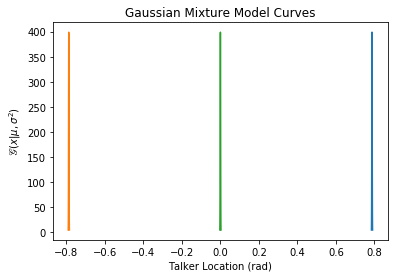

Talker Locations:
Degrees: ------------
[[ 45.12452986]
 [-45.12452986]
 [  0.        ]]
---------------------

Radians: ------------
[[ 0.78757162]
 [-0.78757162]
 [ 0.        ]]
---------------------


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

for n in range(num_lowest_a):
    mu = GM.means_[n][0]
    variance = GM.covariances_[n]
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title('Gaussian Mixture Model Curves')
plt.xlabel('Talker Location (rad)')
plt.ylabel('$\mathscr{G}(x|\mu,\sigma^{2})$')
#plt.savefig('GMMCurves.png', dpi=700)
plt.show()

print('Talker Locations:')
print('Degrees: ------------')
print((GM.means_)*180/np.pi)
print('---------------------')
print('')
print('Radians: ------------')
print(GM.means_)
print('---------------------')

## Predicted Talker Locations:

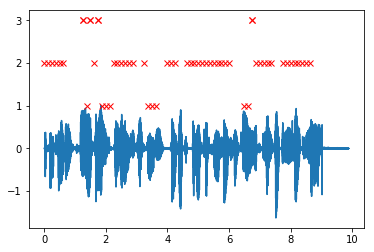

In [10]:
plt.plot(timeArrayInput, normalise(OUTPUT[0]))
plt.plot(TimeArray, GM.predict(np.array(Output_Angles).reshape(-1, 1))+1, 'rx')
plt.show()

# Use Beamforming to Extract Talker Information

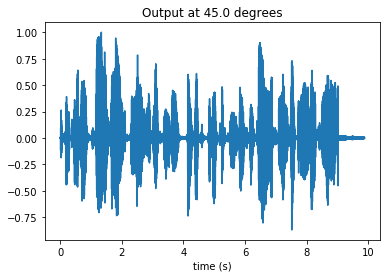

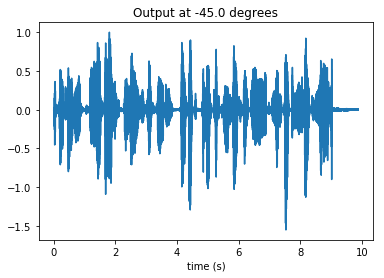

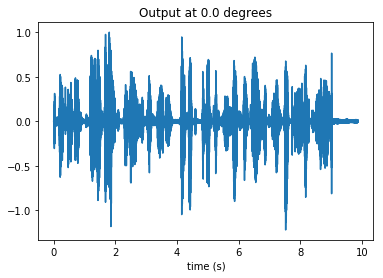

done


In [11]:
for m in GM.means_:
    label = m[0]*180/np.pi
    # find a way of getting the right output from the algorithm, I know its right
    Steer_Angle = m[0]
    Phase = Generate_Phase(mic, Steer_Angle)
    FullOutput = Beam_Form(OUTPUT, fs, Phase)
    
    plt.plot(np.linspace(0, (1/fs)*len(FullOutput), len(FullOutput)), FullOutput)
    title = 'Output at ' + str(round(label)) + ' degrees'
    plt.title(title)
    plt.xlabel('time (s)')
    plt.show()
    
    wavfile.write('output'+str(round(label))+'.wav', fs, FullOutput)

print('done')

# Multiple Speech Source Dominance Testing

/Volumes/RED_HD/DISSERTATION/Dataset2/Speech_Segments/All does not exist
no of exceptions: 0


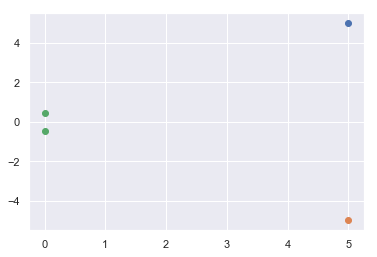

In [12]:
# run this like 500 times and take the average 
fs = 22050

import numpy as np
S1 = np.linspace(0.1, 1, num=20)
S2 = np.linspace(1, 0.1, num=20)

LR = 10*np.log10(S1/S2)
mean = 0
std = 1
# Broadband Identical Signals
path = '/Volumes/RED_HD/DISSERTATION/Dataset2/Speech_Segments/All'
SPEECH_FILES = process_path(path)

a = 0
b = 0.250
A = int(round(a*fs))
B = int(round(b*fs))

LEFT_FULL = []
RIGHT_FULL = []
for num in range(len(SPEECH_FILES)-1):
    print(num)
    fs1, sig1 = wavfile.read(SPEECH_FILES[num])
    sig1 = normalise(sig1[A:B])
    fs2, sig2 = wavfile.read(SPEECH_FILES[num+1])
    sig2 = normalise(sig2[A:B])

    LEFT = []
    RIGHT = []
    for s1 in range(len(S1)):
        Sig1 = sig1 * S1[s1]
        Sig2 = sig2 * S2[s1]

        SigLoc1 = [10, 10]
        SigLoc2 = [10, -10]

        Signal = [Sig1, Sig2]
        Source = [SigLoc1, SigLoc2]

        N = 2
        L = 0.5
        Mics, mic = generate_linear_array(N, L)

        OUTPUT = line_array_time_multi_sources(mic, fs, Source, Signal)

        tdoa = TDOA()
        Rij= tdoa.xcor(OUTPUT[0], OUTPUT[1])
        dT = tdoa.get_dT(Rij, fs)
        angle = tdoa.get_angle(tdoa, Mics, OUTPUT, fs)
        try:
            left = (angle['Left']*180/np.pi)

            right = (angle['Right']*180/np.pi)
        except: 
            print('none')
            break

        LEFT.append(left)
        RIGHT.append(right)
    LEFT_FULL.append(LEFT)
    RIGHT_FULL.append(RIGHT)
    
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns; sns.set()
    
plt.scatter(Source[0][0], Source[0][1])
plt.scatter(Source[1][0], Source[1][1])
plt.scatter([mic[0][0], mic[1][0]], [mic[0][1], mic[1][1]])
plt.show()


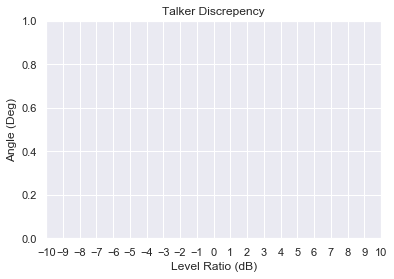

In [13]:
# left
i = 0
for Left in np.array(LEFT_FULL).T:
    point = LR[i]
    s =0
    left = []
    for l in Left:
        if not math.isnan(l):
            s += 1
            left.append(l)
    ave = np.sum(left)/len(left)
    i += 1
    plt.scatter(point, ave, s=s*10, c='b', marker='x')
    
# right
i = 0
for Right in np.array(RIGHT_FULL).T:
    point = LR[i]
    s =0
    right = []
    for r in Right:
        if not math.isnan(r):
            s += 1
            right.append(r)
    ave = np.sum(right)/len(right)
    i += 1
    plt.scatter(point, ave, s=s*10, c='r', marker='x')

plt.title('Talker Discrepency')
plt.xticks([-10, -8, -9, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ylabel('Angle (Deg)')
plt.xlabel('Level Ratio (dB)')
#plt.savefig('Talker Angle Descrepancy.png', dpi=700)
plt.show()